# MODEL TESTING
---
---
### *Various regression models were tested on the average and high cycling period train datasets. Commented out models to prevent run times; results are in the commented out portions.*

# Table of Contents
---
### [Average Cycling Period Model Testing](#Average-Cycling-Period-Model-Testing)
> ### [Average Cycling Period Best Model](#Average-Cycling-Period-Best-Model---XGBoost-w/o-Polynomial)
### [High Cycling Period Model Testing](#High-Cycling-Period-Modeling)
> ### [High Cycling Period Best Model](#High-Cycling-Period-Best-Model---XGBoost-w/-Polynomial)

# Sources and Adaptations From
---

In [1]:
# Various modeling lessons and breakfast hours from DSI 523
# https://medium.com/towards-data-science/loss-functions-and-their-use-in-neural-networks-a470e703f1e9
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber
# https://towardsdatascience.com/what-is-batch-normalization-46058b4f583
# https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model
# https://machinelearningmastery.com/xgboost-for-regression/
# https://towardsdatascience.com/getting-started-with-xgboost-in-scikit-learn-f69f5f470a97
# https://xgboost.readthedocs.io/en/latest/parameter.html
# https://www.python-graph-gallery.com/42-custom-linear-regression-fit-seaborn

# Imports
---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter("ignore")

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.losses import MeanAbsoluteError, Huber

import pickle

In [3]:
a_df = pd.read_csv('../data/average/a_df.csv')
h_df = pd.read_csv('../data/high/h_df.csv')

# Average Cycling Period Modeling
---

In [4]:
a_df.head()

,timestamp,latitude,longitude,elevation,dt,heart_rate,bearing,time_diff_s,total_time_s,ele_diff_m,total_ele_change_m,lat_lon,dist_diff_km,total_dist_km,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg
0,2022-07-20 16:07:45+00:00,38.773466,-121.363686,35.799999,1658333265,78,0.000000,0,0,0.000000,0.0,"(38.77346634864807, -121.36368582956493)",0.0000,0.0000,297.65,297.17,1019,39,282.80,1,0.45,177
1,2022-07-20 16:07:46+00:00,38.773542,-121.363672,35.599998,1658333266,79,8.292053,1,1,-0.200001,-0.2,"(38.77354153431952, -121.36367183178663)",0.0084,0.0084,297.65,297.17,1019,39,282.80,1,0.45,177
2,2022-07-20 16:07:49+00:00,38.773630,-121.363682,35.200001,1658333269,82,-5.321180,3,4,-0.399998,-0.6,"(38.77363029867411, -121.36368239298463)",0.0099,0.0183,297.65,297.17,1019,39,282.80,1,0.45,177
3,2022-07-20 16:07:51+00:00,38.773789,-121.363733,35.000000,1658333271,83,-13.956066,2,6,-0.200001,-0.8,"(38.77378871664405, -121.36373268440366)",0.0181,0.0364,297.67,297.17,1019,38,282.43,1,0.45,177
4,2022-07-20 16:07:52+00:00,38.773786,-121.363766,35.000000,1658333272,83,-96.936537,1,7,0.000000,-0.8,"(38.77378553152084, -121.36376612819731)",0.0029,0.0393,297.67,297.17,1019,38,282.43,1,0.45,177


## X, y, train_test_split
---

In [5]:
a_df.columns

Index(['timestamp', 'latitude', 'longitude', 'elevation', 'dt', 'heart_rate',
       'bearing', 'time_diff_s', 'total_time_s', 'ele_diff_m',
       'total_ele_change_m', 'lat_lon', 'dist_diff_km', 'total_dist_km',
       'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds',
       'wind_speed', 'wind_deg'],
      dtype='object')

In [6]:
a_features = ['elevation', 'bearing', 'time_diff_s', 'total_time_s', 'ele_diff_m',
       'total_ele_change_m', 'dist_diff_km', 'total_dist_km',
       'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds',
       'wind_speed', 'wind_deg']
a_X = a_df[a_features]
a_y = a_df['heart_rate']

a_X_train, a_X_test, a_y_train, a_y_test = train_test_split(a_X, a_y, random_state = 42)

In [7]:
a_y.mean()

130.21652421652422

### StandardScaler X_train and X_test for testing

In [8]:
a_ss = StandardScaler()
a_X_train_sc = a_ss.fit_transform(a_X_train)
a_X_test_sc = a_ss.transform(a_X_test)

### Polynomial X_train and X_test for testing

In [9]:
a_poly = PolynomialFeatures()
a_X_train_sc_p = a_poly.fit_transform(a_X_train_sc)
a_X_test_sc_p = a_poly.fit_transform(a_X_test_sc)

## Linear Regression
---

In [10]:
'''
a_lr = LinearRegression()
a_lr.fit(a_X_train_sc, a_y_train)
print(f'Linear Regression Train R2 Score: {a_lr.score(a_X_train_sc, a_y_train)}')
print(f'Linear Regression Test R2 Score: {a_lr.score(a_X_test_sc, a_y_test)}')
'''
'''
Linear Regression Train R2 Score: 0.5260233155015783
Linear Regression Test R2 Score: 0.5322513167399172
'''

'\nLinear Regression Train R2 Score: 0.5260233155015783\nLinear Regression Test R2 Score: 0.5322513167399172\n'

### Linear Regression Pipeline (StandardScaler, Polynomial)

In [11]:
'''
a_lr_pipe = Pipeline([
    ('a_ss', StandardScaler()),
    ('a_poly', PolynomialFeatures()),
    ('a_lr', LinearRegression())
])

a_lr_pipe.fit(a_X_train, a_y_train)
print(f'LR Pipe Train R2 Score: {a_lr_pipe.score(a_X_train, a_y_train)}')
print(f'LR Pipe Test R2 Score: {a_lr_pipe.score(a_X_test, a_y_test)}')
'''
'''
LR Pipe Train R2 Score: 0.8082482755481244
LR Pipe Test R2 Score: 0.7906546450250773
'''

'\nLR Pipe Train R2 Score: 0.8082482755481244\nLR Pipe Test R2 Score: 0.7906546450250773\n'

## Regressor Boosting
---

### AdaBoost with Linear Regression Base Estimator

In [12]:
'''
a_ada_lr = AdaBoostRegressor(base_estimator = LinearRegression(), random_state = 42)

a_ada_lr.fit(a_X_train_sc_p, a_y_train)
print(f'Ada LR Train R2 Score: {a_ada_lr.score(a_X_train_sc_p, a_y_train)}')
print(f'Ada LR Test R2 Score: {a_ada_lr.score(a_X_test_sc_p, a_y_test)}')
'''
'''
Ada LR Train R2 Score: 0.8046423913777858
Ada LR Test R2 Score: 0.776694380832758
'''

'\nAda LR Train R2 Score: 0.8046423913777858\nAda LR Test R2 Score: 0.776694380832758\n'

### AdaBoost with Decision Tree Base Estimator

In [13]:
'''
a_ada_dt = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), random_state = 42)

a_ada_dt_params = {
    'n_estimators': [50, 100, 150, 200],
    'base_estimator__max_depth': [1, 2, 5]
}

a_gs_ada_dt = GridSearchCV(a_ada_dt, param_grid = a_ada_dt_params, cv = 5)
a_gs_ada_dt.fit(a_X_train_sc, a_y_train)
print(a_gs_ada_dt.best_score_)
print(a_gs_ada_dt.best_params_)
print(f'Ada DT Train R2 Score: {a_gs_ada_dt.score(a_X_train_sc, a_y_train)}')
print(f'Ada DT Test R2 Score: {a_gs_ada_dt.score(a_X_test_sc, a_y_test)}')
'''

'''
0.868164587298871
{'base_estimator__max_depth': 5, 'n_estimators': 200}
Ada DT Train R2 Score: 0.8756108134812447
Ada DT Test R2 Score: 0.8730399805443708
'''

"\n0.868164587298871\n{'base_estimator__max_depth': 5, 'n_estimators': 200}\nAda DT Train R2 Score: 0.8756108134812447\nAda DT Test R2 Score: 0.8730399805443708\n"

### AdaBoost with Random Forest Base Estimator

In [14]:
'''
a_ada_rf = AdaBoostRegressor(base_estimator = RandomForestRegressor(), random_state = 42)

a_ada_rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'base_estimator__max_depth': [1, 2, 5]
}

a_gs_ada_rf = GridSearchCV(a_ada_rf, param_grid = a_ada_rf_params, cv = 5)
a_gs_ada_rf.fit(a_X_train_sc, a_y_train)
print(a_gs_ada_rf.best_score_)
print(a_gs_ada_rf.best_params_)
print(f'Ada DT Train R2 Score: {a_gs_ada_rf.score(a_X_train_sc, a_y_train)}')
print(f'Ada DT Test R2 Score: {a_gs_ada_rf.score(a_X_test_sc, a_y_test)}')
'''
'''
0.844253394135492
{'base_estimator__max_depth': 5, 'n_estimators': 50}
Ada DT Train R2 Score: 0.8526320077631239
Ada DT Test R2 Score: 0.8512220020729748
'''

"\n0.844253394135492\n{'base_estimator__max_depth': 5, 'n_estimators': 50}\nAda DT Train R2 Score: 0.8526320077631239\nAda DT Test R2 Score: 0.8512220020729748\n"

### Gradient Boosting

In [15]:
'''
# Instantiate
a_gboost = GradientBoostingRegressor()

a_gboost_params = {
    'max_depth': [2, 3, 4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [0.8, .1, .12]
}

# Gridsearch
a_gb_gs = GridSearchCV(a_gboost, param_grid = a_gboost_params, cv = 5)
a_gb_gs.fit(a_X_train_sc, a_y_train)

# Metrics
print(f'GridSearch Best Score: {a_gb_gs.best_score_}')
print(a_gb_gs.best_params_)
print(f'GBoost Train R2 Score: {a_gb_gs.score(a_X_train_sc, a_y_train)}')
print(f'GBoost Test R2 Score: {a_gb_gs.score(a_X_test_sc, a_y_test)}')

a_gb_y_true = a_y_test
a_gb_y_pred = a_gb_gs.predict(a_X_test_sc)

# MAE
print(f'Mean Absolute Error: {mean_absolute_error(a_gb_y_true, a_gb_y_pred)}')

# MSE
print(f'Mean Squared Error: {mean_squared_error(a_gb_y_true, a_gb_y_pred)}')
'''
'''
GridSearch Best Score: 0.964003581281308
{'learning_rate': 0.8, 'max_depth': 4, 'n_estimators': 150}
GBoost Train R2 Score: 0.9888934084696182
GBoost Test R2 Score: 0.9709606783777225
Mean Absolute Error: 2.7824393977965642
Mean Squared Error: 14.658521217024555
'''

"\nGridSearch Best Score: 0.964003581281308\n{'learning_rate': 0.8, 'max_depth': 4, 'n_estimators': 150}\nGBoost Train R2 Score: 0.9888934084696182\nGBoost Test R2 Score: 0.9709606783777225\nMean Absolute Error: 2.7824393977965642\nMean Squared Error: 14.658521217024555\n"

### XGBoost w/o Polynomial Features

In [16]:
'''
# Instantiate
a_xgboost = XGBRegressor()

# Gridsearch
a_xgboost_params = {
    'max_depth': [2, 3, 4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [0.8, .1, .12]
}

a_xgb_gs = GridSearchCV(a_xgboost, param_grid = a_xgboost_params, cv = 5)
a_xgb_gs.fit(a_X_train_sc, a_y_train)

# Metrics
print(f'GridSearch Best Score: {a_xgb_gs.best_score_}')
print(a_xgb_gs.best_params_)
print(f'XGBoost Train R2 Score: {a_xgb_gs.score(a_X_train_sc, a_y_train)}')
print(f'XGBoost Test R2 Score: {a_xgb_gs.score(a_X_test_sc, a_y_test)}')

a_xgb_y_true = a_y_test
a_xgb_y_pred = a_xgb_gs.predict(a_X_test_sc)

# MAE
print(f'Mean Absolute Error: {mean_absolute_error(a_xgb_y_true, a_xgb_y_pred)}')

# MSE
print(f'Mean Squared Error: {mean_squared_error(a_xgb_y_true, a_xgb_y_pred)}')
'''
'''
GridSearch Best Score: 0.9659966627636546
{'learning_rate': 0.8, 'max_depth': 4, 'n_estimators': 150}
XGBoost Train R2 Score: 0.9888381686104007
XGBoost Test R2 Score: 0.9719382323708556
Mean Absolute Error: 2.7619688805285496
Mean Squared Error: 14.165069746789941
'''

"\nGridSearch Best Score: 0.9659966627636546\n{'learning_rate': 0.8, 'max_depth': 4, 'n_estimators': 150}\nXGBoost Train R2 Score: 0.9888381686104007\nXGBoost Test R2 Score: 0.9719382323708556\nMean Absolute Error: 2.7619688805285496\nMean Squared Error: 14.165069746789941\n"

## Neural Net Regressor
---

### X, y, train_test_split, StandardScaler

In [17]:
'''
a_X_nn = a_df[a_features]
a_y_nn = a_df['heart_rate']

a_X_nn = np.array(a_X_nn)
a_y_nn = np.array(a_y_nn)

a_X_nn_train, a_X_nn_test, a_y_nn_train, a_y_nn_test = train_test_split(a_X_nn, a_y_nn, random_state = 42)

a_ss_nn = StandardScaler()
a_X_nn_train_sc = a_ss_nn.fit_transform(a_X_nn_train)
a_X_nn_test_sc = a_ss.transform(a_X_nn_test)
'''

"\na_X_nn = a_df[a_features]\na_y_nn = a_df['heart_rate']\n\na_X_nn = np.array(a_X_nn)\na_y_nn = np.array(a_y_nn)\n\na_X_nn_train, a_X_nn_test, a_y_nn_train, a_y_nn_test = train_test_split(a_X_nn, a_y_nn, random_state = 42)\n\na_ss_nn = StandardScaler()\na_X_nn_train_sc = a_ss_nn.fit_transform(a_X_nn_train)\na_X_nn_test_sc = a_ss.transform(a_X_nn_test)\n"

In [18]:
# a_X_nn[0].shape

In [19]:
'''
# Instantiate
a_model_nn = Sequential()

# Layers
a_model_nn.add(Dense(128, input_dim = 16, activation = 'relu'))

a_model_nn.add(BatchNormalization())
a_model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.1)))
a_model_nn.add(Dense(128, activation = 'relu', kernel_regularizer = l2(.5)))
a_model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.1)))
a_model_nn.add(Dense(128, activation = 'relu', kernel_regularizer = l2(.5))) 
a_model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.1))) 
a_model_nn.add(Dense(1, kernel_regularizer = l2(.5)))
'''

"\n# Instantiate\na_model_nn = Sequential()\n\n# Layers\na_model_nn.add(Dense(128, input_dim = 16, activation = 'relu'))\n\na_model_nn.add(BatchNormalization())\na_model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.1)))\na_model_nn.add(Dense(128, activation = 'relu', kernel_regularizer = l2(.5)))\na_model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.1)))\na_model_nn.add(Dense(128, activation = 'relu', kernel_regularizer = l2(.5))) \na_model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.1))) \na_model_nn.add(Dense(1, kernel_regularizer = l2(.5)))\n"

In [20]:
'''
# compile
a_model_nn.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
'''

"\n# compile\na_model_nn.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])\n"

In [21]:
'''
# fit
a_history_nn = a_model_nn.fit(a_X_nn_train_sc, a_y_nn_train, epochs = 500, verbose = 1, 
                          validation_data = (a_X_nn_test_sc, a_y_nn_test))
'''

'\n# fit\na_history_nn = a_model_nn.fit(a_X_nn_train_sc, a_y_nn_train, epochs = 500, verbose = 1, \n                          validation_data = (a_X_nn_test_sc, a_y_nn_test))\n'

In [22]:
'''
#breakfast hour
# plot train and test loss (mse)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(a_history_nn.history['loss'], color = 'green')
ax[1].plot(a_history_nn.history['val_loss'], color = 'blue')

ax[0].set_title('Train')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss = MSE')

ax[1].set_title('Test')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Loss = MSE');
'''

"\n#breakfast hour\n# plot train and test loss (mse)\nfig, ax = plt.subplots(1, 2, figsize=(15, 5))\n\nax[0].plot(a_history_nn.history['loss'], color = 'green')\nax[1].plot(a_history_nn.history['val_loss'], color = 'blue')\n\nax[0].set_title('Train')\nax[0].set_xlabel('epochs')\nax[0].set_ylabel('Loss = MSE')\n\nax[1].set_title('Test')\nax[1].set_xlabel('epochs')\nax[1].set_ylabel('Loss = MSE');\n"

In [23]:
'''
# https://medium.com/towards-data-science/loss-functions-and-their-use-in-neural-networks-a470e703f1e9
a_nn_y_true = a_y_nn_test
a_nn_y_pred = a_model_nn.predict(a_X_nn_test_sc)

# R2
print(f'Test R2: {r2_score(a_nn_y_true, a_nn_y_pred)}')

# MAE
mae = MeanAbsoluteError()
print(f'Mean Absolute Error: {mae(a_nn_y_true, a_nn_y_pred)}')

# Huber
huber = Huber()
print(f'Huber Loss: {huber(a_nn_y_true, a_nn_y_pred)}')
'''
'''
118/118 [==============================] - 0s 1ms/step
Test R2: 0.9330577294184806
Mean Absolute Error: 24.59176254272461
Huber Loss: 24.096338272094727
'''

'\n118/118 [==============================] - 0s 1ms/step\nTest R2: 0.9330577294184806\nMean Absolute Error: 24.59176254272461\nHuber Loss: 24.096338272094727\n'

# Average Cycling Period Best Model - XGBoost w/o Polynomial
---

### GridSearch 
- Best Score: 0.9659966627636546
- learning_rate: 0.8  
- max_depth: 4
- n_estimators: 150

### Scores & Errors
- Train R2 Score: 0.9888381686104007
- Test R2 Score: 0.9719382323708556
- Mean Absolute Error: 2.7619688805285496
- Mean Squared Error: 14.165069746789941

In [24]:
'''
a_X_test_df = pd.DataFrame(a_X_test)
a_X_test_df.columns = a_features
a_X_test_df['hr_preds'] = a_xgb_gs.predict(a_X_test_sc)
a_X_test_df['heart_rate'] = list(a_y_test)
a_X_test_df.shape
'''

"\na_X_test_df = pd.DataFrame(a_X_test)\na_X_test_df.columns = a_features\na_X_test_df['hr_preds'] = a_xgb_gs.predict(a_X_test_sc)\na_X_test_df['heart_rate'] = list(a_y_test)\na_X_test_df.shape\n"

In [25]:
# a_X_test_df.to_csv('../data/average/a_X_test_preds_df.csv', index = False)

In [26]:
a_X_test_df = pd.read_csv('../data/average/a_X_test_preds_df.csv')
a_X_test_df.head()

,elevation,bearing,time_diff_s,total_time_s,ele_diff_m,total_ele_change_m,dist_diff_km,total_dist_km,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,hr_preds,heart_rate
0,30.200001,107.741305,2,1578,-0.199999,-5.6,0.0043,3.9019,299.90,299.57,1015,34,282.75,0,0.45,225,88.65585,88
1,18.200001,-91.341952,2,1379,0.000000,-17.2,0.0115,9.1492,307.13,306.96,1013,33,288.59,0,0.45,306,156.83527,161
2,45.599998,-172.191340,6,11520,-0.200001,4.8,0.0348,43.4648,303.43,302.33,1010,32,284.91,0,3.09,210,143.11284,140
3,30.000000,70.271727,1,2647,0.200001,-5.4,0.0057,15.2914,306.87,305.91,1012,29,286.37,0,5.66,170,133.06080,135
4,38.000000,139.973764,7,4431,-0.400002,2.6,0.0398,23.8649,298.83,298.63,1016,45,286.02,0,1.34,190,119.53260,120


In [27]:
a_X_test_df[['heart_rate', 'hr_preds']].describe().T

,count,mean,std,min,25%,50%,75%,max
heart_rate,3774.0,130.082141,22.470327,65.00000,115.000000,133.000000,148.000000,173.00000
hr_preds,3774.0,130.082674,22.129823,66.56656,115.416437,133.040595,147.636647,172.71858


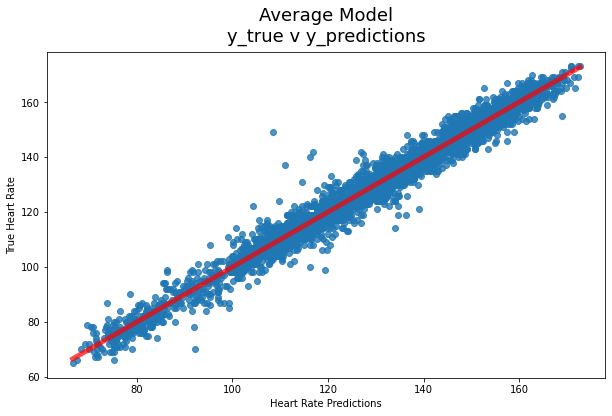

<Figure size 432x288 with 0 Axes>

In [55]:
# average test split - plot predictions and true
plt.figure(figsize = (10,6))
sns.regplot(x=a_X_test_df["hr_preds"], y=a_X_test_df["heart_rate"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.title('Average Model\ny_true v y_predictions', pad = 10, fontsize = 18)
plt.xlabel('Heart Rate Predictions')
plt.ylabel('True Heart Rate')
plt.show();

plt.savefig('../images/a_model.png')
plt.savefig('../images/a_model.jpeg')

## Pickle That

In [29]:
'''
# Pickle a_XGB
with open('../models/a_model_xgb.pkl', 'wb') as f:
    pickle.dump(a_xgb_gs, f)
'''

"\n# Pickle a_XGB\nwith open('../models/a_model_xgb.pkl', 'wb') as f:\n    pickle.dump(a_xgb_gs, f)\n"

# High Cycling Period Modeling
---

## X, y, train_test_split
---

In [30]:
h_df.columns

Index(['timestamp', 'latitude', 'longitude', 'elevation', 'dt', 'heart_rate',
       'bearing', 'time_diff_s', 'total_time_s', 'ele_diff_m',
       'total_ele_change_m', 'lat_lon', 'dist_diff_km', 'total_dist_km',
       'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds',
       'wind_speed', 'wind_deg'],
      dtype='object')

In [31]:
h_features = ['elevation', 'bearing', 'time_diff_s', 'total_time_s', 'ele_diff_m',
       'total_ele_change_m', 'dist_diff_km', 'total_dist_km',
       'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds',
       'wind_speed', 'wind_deg']
h_X = h_df[h_features]
h_y = h_df['heart_rate']

h_X_train, h_X_test, h_y_train, h_y_test = train_test_split(h_X, h_y, random_state = 42)

In [32]:
h_y.mean()

130.53650259067356

### StandardScaler X_train and X_test for testing

In [33]:
h_ss = StandardScaler()
h_X_train_sc = h_ss.fit_transform(h_X_train)
h_X_test_sc = h_ss.transform(h_X_test)

### Polynomial X_train and X_test for testing

In [34]:
h_poly = PolynomialFeatures()
h_X_train_sc_p = h_poly.fit_transform(h_X_train_sc)
h_X_test_sc_p = h_poly.fit_transform(h_X_test_sc)

## Linear Regression
---

In [35]:
'''
a_lr = LinearRegression()
a_lr.fit(a_X_train_sc, a_y_train)
print(f'Linear Regression Train R2 Score: {a_lr.score(a_X_train_sc, a_y_train)}')
print(f'Linear Regression Test R2 Score: {a_lr.score(a_X_test_sc, a_y_test)}')
'''
'''
Linear Regression Train R2 Score: 0.5260233155015783
Linear Regression Test R2 Score: 0.5322513167399172
'''

'\nLinear Regression Train R2 Score: 0.5260233155015783\nLinear Regression Test R2 Score: 0.5322513167399172\n'

### Linear Regression Pipeline (StandardScaler, Polynomial)

In [36]:
'''
a_lr_pipe = Pipeline([
    ('a_ss', StandardScaler()),
    ('a_poly', PolynomialFeatures()),
    ('a_lr', LinearRegression())
])

a_lr_pipe.fit(a_X_train, a_y_train)
print(f'LR Pipe Train R2 Score: {a_lr_pipe.score(a_X_train, a_y_train)}')
print(f'LR Pipe Test R2 Score: {a_lr_pipe.score(a_X_test, a_y_test)}')
'''
'''
LR Pipe Train R2 Score: 0.8082482755481244
LR Pipe Test R2 Score: 0.7906546450250773
'''
'''
LR Pipe Train R2 Score: 0.8082482755481244
LR Pipe Test R2 Score: 0.7906546450250773
'''

'\nLR Pipe Train R2 Score: 0.8082482755481244\nLR Pipe Test R2 Score: 0.7906546450250773\n'

## Regressor Boosting
---

### AdaBoost with Linear Regression Base Estimator

In [37]:
'''
a_ada_lr = AdaBoostRegressor(base_estimator = LinearRegression(), random_state = 42)

a_ada_lr.fit(a_X_train_sc_p, a_y_train)
print(f'Ada LR Train R2 Score: {a_ada_lr.score(a_X_train_sc_p, a_y_train)}')
print(f'Ada LR Test R2 Score: {a_ada_lr.score(a_X_test_sc_p, a_y_test)}')
'''
'''
Ada LR Train R2 Score: 0.8046423913777858
Ada LR Test R2 Score: 0.776694380832758
'''

'\nAda LR Train R2 Score: 0.8046423913777858\nAda LR Test R2 Score: 0.776694380832758\n'

### AdaBoost with Decision Tree Base Estimator

In [38]:
'''
a_ada_dt = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), random_state = 42)

a_ada_dt_params = {
    'n_estimators': [50, 100, 150, 200],
    'base_estimator__max_depth': [1, 2, 5]
}

a_gs_ada_dt = GridSearchCV(a_ada_dt, param_grid = a_ada_dt_params, cv = 5)
a_gs_ada_dt.fit(a_X_train_sc, a_y_train)
print(a_gs_ada_dt.best_score_)
print(a_gs_ada_dt.best_params_)
print(f'Ada DT Train R2 Score: {a_gs_ada_dt.score(a_X_train_sc, a_y_train)}')
print(f'Ada DT Test R2 Score: {a_gs_ada_dt.score(a_X_test_sc, a_y_test)}')
'''

'''
0.868164587298871
{'base_estimator__max_depth': 5, 'n_estimators': 200}
Ada DT Train R2 Score: 0.8756108134812447
Ada DT Test R2 Score: 0.8730399805443708
'''

"\n0.868164587298871\n{'base_estimator__max_depth': 5, 'n_estimators': 200}\nAda DT Train R2 Score: 0.8756108134812447\nAda DT Test R2 Score: 0.8730399805443708\n"

### AdaBoost with Random Forest Base Estimator

In [39]:
'''
a_ada_rf = AdaBoostRegressor(base_estimator = RandomForestRegressor(), random_state = 42)

a_ada_rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'base_estimator__max_depth': [1, 2, 5]
}

a_gs_ada_rf = GridSearchCV(a_ada_rf, param_grid = a_ada_rf_params, cv = 5)
a_gs_ada_rf.fit(a_X_train_sc, a_y_train)
print(a_gs_ada_rf.best_score_)
print(a_gs_ada_rf.best_params_)
print(f'Ada DT Train R2 Score: {a_gs_ada_rf.score(a_X_train_sc, a_y_train)}')
print(f'Ada DT Test R2 Score: {a_gs_ada_rf.score(a_X_test_sc, a_y_test)}')
'''
'''
0.844253394135492
{'base_estimator__max_depth': 5, 'n_estimators': 50}
Ada DT Train R2 Score: 0.8526320077631239
Ada DT Test R2 Score: 0.8512220020729748
'''

"\n0.844253394135492\n{'base_estimator__max_depth': 5, 'n_estimators': 50}\nAda DT Train R2 Score: 0.8526320077631239\nAda DT Test R2 Score: 0.8512220020729748\n"

### Gradient Boosting

In [40]:
'''
# Instantiate
h_gboost = GradientBoostingRegressor()

h_gboost_params = {
    'max_depth': [2, 3, 4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [0.8, .1, .12]
}

# Gridsearch
h_gb_gs = GridSearchCV(h_gboost, param_grid = h_gboost_params, cv = 5)
h_gb_gs.fit(h_X_train_sc, h_y_train)

# Metrics
print(f'GridSearch Best Score: {h_gb_gs.best_score_}')
print(h_gb_gs.best_params_)
print(f'GBoost Train R2 Score: {h_gb_gs.score(h_X_train_sc, h_y_train)}')
print(f'GBoost Test R2 Score: {h_gb_gs.score(h_X_test_sc, h_y_test)}')

h_gb_y_true = h_y_test
h_gb_y_pred = h_gb_gs.predict(h_X_test_sc)

# MAE
print(f'Mean Absolute Error: {mean_absolute_error(h_gb_y_true, h_gb_y_pred)}')

# MSE
print(f'Mean Squared Error: {mean_squared_error(h_gb_y_true, h_gb_y_pred)}')
'''
'''
GridSearch Best Score: 0.8839302929148015
{'learning_rate': 0.8, 'max_depth': 4, 'n_estimators': 150}
GBoost Train R2 Score: 0.9313990799272799
GBoost Test R2 Score: 0.8849043647905527
Mean Absolute Error: 4.056626449058407
Mean Squared Error: 30.153280288091132
'''

"\nGridSearch Best Score: 0.8839302929148015\n{'learning_rate': 0.8, 'max_depth': 4, 'n_estimators': 150}\nGBoost Train R2 Score: 0.9313990799272799\nGBoost Test R2 Score: 0.8849043647905527\nMean Absolute Error: 4.056626449058407\nMean Squared Error: 30.153280288091132\n"

### XGBoost w/ Polynomial Features

In [41]:
'''
# Instantiate
h_xgboost = XGBRegressor()

# Gridsearch
h_xgboost_params = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 125, 150],
    'learning_rate': [0.8, .1, .12],
    'reg_lambda': [1, 2]
}

h_xgb_gs = GridSearchCV(h_xgboost, param_grid = h_xgboost_params, cv = 5)
h_xgb_gs.fit(h_X_train_sc_p, h_y_train)

# Metrics
print(f'GridSearch Best Score: {h_xgb_gs.best_score_}')
print(h_xgb_gs.best_params_)
print(f'XGBoost Train R2 Score: {h_xgb_gs.score(h_X_train_sc_p, h_y_train)}')
print(f'XGBoost Test R2 Score: {h_xgb_gs.score(h_X_test_sc_p, h_y_test)}')

h_xgb_y_true = h_y_test
h_xgb_y_pred = h_xgb_gs.predict(h_X_test_sc_p)

# MAE
print(f'Mean Absolute Error: {mean_absolute_error(h_xgb_y_true, h_xgb_y_pred)}')

# MSE
print(f'Mean Squared Error: {mean_squared_error(h_xgb_y_true, h_xgb_y_pred)}')
'''
'''
GridSearch Best Score: 0.9066727023063461
{'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 150, 'reg_lambda': 1}
XGBoost Train R2 Score: 0.972496927983201
XGBoost Test R2 Score: 0.9227343527337118
Mean Absolute Error: 3.2724629223284945
Mean Squared Error: 20.24240723309317
'''

"\nGridSearch Best Score: 0.9066727023063461\n{'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 150, 'reg_lambda': 1}\nXGBoost Train R2 Score: 0.972496927983201\nXGBoost Test R2 Score: 0.9227343527337118\nMean Absolute Error: 3.2724629223284945\nMean Squared Error: 20.24240723309317\n"

## Neural Net Regressor
---

### X, y, train_test_split, StandardScaler

In [42]:
'''
h_X_nn = h_df[h_features]
h_y_nn = h_df['heart_rate']

h_X_nn = np.array(h_X_nn)
h_y_nn = np.array(h_y_nn)

h_X_nn_train, h_X_nn_test, h_y_nn_train, h_y_nn_test = train_test_split(h_X_nn, h_y_nn, random_state = 42)

h_ss_nn = StandardScaler()
h_X_nn_train_sc = h_ss_nn.fit_transform(h_X_nn_train)
h_X_nn_test_sc = h_ss.transform(h_X_nn_test)

h_poly = PolynomialFeatures()
h_X_nn_train_sc_p = h_poly.fit_transform(h_X_nn_train_sc)
h_X_nn_test_sc_p = h_poly.fit_transform(h_X_nn_test_sc)
'''

"\nh_X_nn = h_df[h_features]\nh_y_nn = h_df['heart_rate']\n\nh_X_nn = np.array(h_X_nn)\nh_y_nn = np.array(h_y_nn)\n\nh_X_nn_train, h_X_nn_test, h_y_nn_train, h_y_nn_test = train_test_split(h_X_nn, h_y_nn, random_state = 42)\n\nh_ss_nn = StandardScaler()\nh_X_nn_train_sc = h_ss_nn.fit_transform(h_X_nn_train)\nh_X_nn_test_sc = h_ss.transform(h_X_nn_test)\n\nh_poly = PolynomialFeatures()\nh_X_nn_train_sc_p = h_poly.fit_transform(h_X_nn_train_sc)\nh_X_nn_test_sc_p = h_poly.fit_transform(h_X_nn_test_sc)\n"

In [43]:
'''
print(h_X_nn[0].shape)
print(h_X_nn_train_sc_p[0].shape)
'''

'\nprint(h_X_nn[0].shape)\nprint(h_X_nn_train_sc_p[0].shape)\n'

In [44]:
'''
# Instantiate
h_model_nn = Sequential()

# Layers
h_model_nn.add(Dense(128, input_dim = 153, activation = 'relu'))

h_model_nn.add(BatchNormalization())
h_model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.1)))
h_model_nn.add(Dense(128, activation = 'relu', kernel_regularizer = l2(.5))) 
h_model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.1))) 
h_model_nn.add(Dense(1, kernel_regularizer = l2(.5)))
'''

"\n# Instantiate\nh_model_nn = Sequential()\n\n# Layers\nh_model_nn.add(Dense(128, input_dim = 153, activation = 'relu'))\n\nh_model_nn.add(BatchNormalization())\nh_model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.1)))\nh_model_nn.add(Dense(128, activation = 'relu', kernel_regularizer = l2(.5))) \nh_model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.1))) \nh_model_nn.add(Dense(1, kernel_regularizer = l2(.5)))\n"

In [45]:
# compile
# h_model_nn.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

In [46]:
'''
# fit
h_history_nn = h_model_nn.fit(h_X_nn_train_sc, h_y_nn_train, epochs = 500, verbose = 1, 
                          validation_data = (h_X_nn_test_sc_p, h_y_nn_test))
'''

'\n# fit\nh_history_nn = h_model_nn.fit(h_X_nn_train_sc, h_y_nn_train, epochs = 500, verbose = 1, \n                          validation_data = (h_X_nn_test_sc_p, h_y_nn_test))\n'

In [47]:
'''
#breakfast hour
# plot train and test loss (mse)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(h_history_nn.history['loss'], color = 'green')
ax[1].plot(h_history_nn.history['val_loss'], color = 'blue')

ax[0].set_title('Train')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss = MSE')

ax[1].set_title('Test')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Loss = MSE');
'''

"\n#breakfast hour\n# plot train and test loss (mse)\nfig, ax = plt.subplots(1, 2, figsize=(15, 5))\n\nax[0].plot(h_history_nn.history['loss'], color = 'green')\nax[1].plot(h_history_nn.history['val_loss'], color = 'blue')\n\nax[0].set_title('Train')\nax[0].set_xlabel('epochs')\nax[0].set_ylabel('Loss = MSE')\n\nax[1].set_title('Test')\nax[1].set_xlabel('epochs')\nax[1].set_ylabel('Loss = MSE');\n"

In [48]:
'''
# https://medium.com/towards-data-science/loss-functions-and-their-use-in-neural-networks-a470e703f1e9
h_nn_y_true = h_y_nn_test
h_nn_y_pred = h_model_nn.predict(h_X_nn_test_sc)

# R2
print(f'Test R2: {r2_score(h_nn_y_true, h_nn_y_pred)}')

# MAE
mae = MeanAbsoluteError()
print(f'Mean Absolute Error: {mae(h_nn_y_true, h_nn_y_pred)}')

# Huber
huber = Huber()
print(f'Huber Loss: {huber(h_nn_y_true, h_nn_y_pred)}')
'''

'''
302/302 [==============================] - 0s 880us/step
Test R2: 0.7437961674672984
Mean Absolute Error: 16.746091842651367
Huber Loss: 16.25282096862793
'''

'\n302/302 [==============================] - 0s 880us/step\nTest R2: 0.7437961674672984\nMean Absolute Error: 16.746091842651367\nHuber Loss: 16.25282096862793\n'

# High Cycling Period Best Model - XGBoost w/ Polynomial
---

### GridSearch 
- Best Score: 0.9066727023063461
- learning_rate: 0.8
- max_depth: 5
- n_estimators: 150
- reg_lambda: 1

### Scores & Errors
- Train R2 Score: 0.972496927983201
- Test R2 Score: 0.9227343527337118
- Mean Absolute Error: 3.2724629223284945
- Mean Squared Error: 20.24240723309317

In [49]:
'''
h_X_test_df = pd.DataFrame(h_X_test)
h_X_test_df.columns = h_features
h_X_test_df['hr_preds'] = h_xgb_gs.predict(h_X_test_sc_p)
h_X_test_df['heart_rate'] = list(h_y_test)
h_X_test_df.shape
'''

"\nh_X_test_df = pd.DataFrame(h_X_test)\nh_X_test_df.columns = h_features\nh_X_test_df['hr_preds'] = h_xgb_gs.predict(h_X_test_sc_p)\nh_X_test_df['heart_rate'] = list(h_y_test)\nh_X_test_df.shape\n"

In [50]:
# h_X_test_df.to_csv('../data/high/h_X_test_preds_df.csv', index = False)

In [51]:
h_X_test_df = pd.read_csv('../data/high/h_X_test_preds_df.csv')
h_X_test_df.head()

,elevation,bearing,time_diff_s,total_time_s,ele_diff_m,total_ele_change_m,dist_diff_km,total_dist_km,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,hr_preds,heart_rate
0,47.200001,-20.250895,3,15630,0.000000,6.4,0.0244,65.4484,300.66,299.54,1016,19,275.00,0,3.60,250,135.48773,130
1,268.600006,71.512404,1,2519,0.399994,-43.8,0.0044,7.9729,281.32,277.11,1017,79,277.90,20,9.26,280,108.13239,106
2,304.000000,40.228071,3,2036,1.200012,-8.4,0.0122,7.4623,281.12,276.85,1017,78,277.52,20,9.26,280,112.97771,112
3,39.599998,-18.162952,1,765,0.199997,3.2,0.0062,4.7536,298.00,297.17,1011,24,276.07,0,2.06,220,131.03607,129
4,49.000000,107.763619,2,17550,0.200001,8.2,0.0107,75.7113,300.55,299.47,1016,19,274.91,0,2.06,270,138.06866,131


In [52]:
h_X_test_df[['heart_rate', 'hr_preds']].describe().T

,count,mean,std,min,25%,50%,75%,max
heart_rate,9650.0,130.787461,16.186776,69.000000,122.000000,133.00000,142.000000,168.00000
hr_preds,9650.0,130.811154,15.727632,60.254894,122.696488,132.80188,141.589233,168.86269


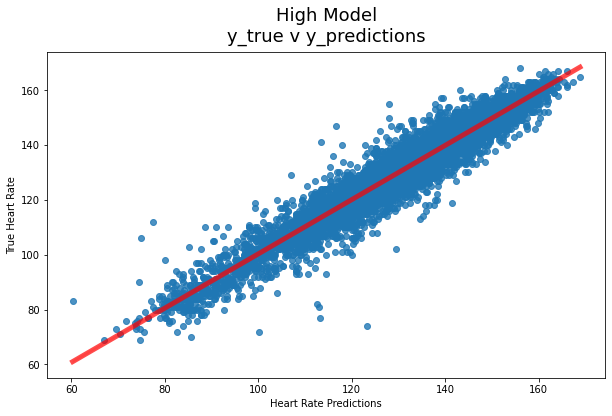

<Figure size 432x288 with 0 Axes>

In [56]:
# average test split - plot predictions and true
plt.figure(figsize = (10,6))
sns.regplot(x=h_X_test_df["hr_preds"], y=h_X_test_df["heart_rate"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.title('High Model\ny_true v y_predictions', pad = 10, fontsize = 18)
plt.xlabel('Heart Rate Predictions')
plt.ylabel('True Heart Rate')
plt.show();

plt.savefig('../images/h_model.png')
plt.savefig('../images/h_model.jpeg')

## Pickle That

In [54]:
'''
# Pickle h_XGB
with open('../models/h_model_xgb.pkl', 'wb') as f:
    pickle.dump(h_xgb_gs, f)
'''

"\n# Pickle h_XGB\nwith open('../models/h_model_xgb.pkl', 'wb') as f:\n    pickle.dump(h_xgb_gs, f)\n"